In [6]:
def load_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return data

def mask_tokens(inputs, tokenizer, mask_probability=0.15):
    labels = inputs.clone()
    probability_matrix = torch.full(labels.shape, mask_probability)
    special_tokens_mask = [
        tokenizer.get_special_tokens_mask(val, already_has_special_tokens=True) for val in labels.tolist()
    ]
    probability_matrix.masked_fill_(torch.tensor(special_tokens_mask, dtype=torch.bool), value=0.0)
    masked_indices = torch.bernoulli(probability_matrix).bool()
    labels[~masked_indices] = -100

    indices_replaced = torch.bernoulli(torch.full(labels.shape, 0.8)).bool() & masked_indices
    inputs[indices_replaced] = tokenizer.convert_tokens_to_ids(tokenizer.mask_token)

    indices_random = torch.bernoulli(torch.full(labels.shape, 0.1)).bool() & masked_indices & ~indices_replaced
    random_words = torch.randint(len(tokenizer.vocab), labels.shape, dtype=torch.long)
    inputs[indices_random] = random_words[indices_random]

    return inputs, labels

def prepare_data(data, tokenizer):
    input_tokens = torch.tensor([tokenizer.convert_tokens_to_ids(tokens) for tokens in data])
    return mask_tokens(input_tokens, tokenizer)

# calculates loss for model on dataset in loader
def evaluate(model, loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in loader:
            input_ids, labels = [x.to(device) for x in batch]
            outputs = model(input_ids, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()

    average_loss = total_loss / len(loader)
    return average_loss

# calculates accuracy for model on dataset in loader
def calculate_accuracy(model, loader):
    model.eval()
    total_correct = 0
    total_masked_tokens = 0
    
    with torch.no_grad():
        for input_ids, labels in loader:
            input_ids, labels = input_ids.to(device), labels.to(device)
            outputs = model(input_ids, labels=labels)
            predictions = outputs.logits.argmax(dim=-1)
            mask = labels != -100  # masked tokens are labeled with -100
            correct_predictions = (predictions == labels) & mask
            total_correct += correct_predictions.sum().item()
            total_masked_tokens += mask.sum().item()
    
    accuracy = total_correct / total_masked_tokens
    return accuracy

In [12]:
import torch
import json
import os
from transformers import BertTokenizer, BertForMaskedLM, BertConfig
from torch.utils.data import DataLoader, TensorDataset

# load tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

#model = BertForMaskedLM.from_pretrained('bert-base-uncased')

config = BertConfig.from_pretrained('bert-base-uncased')
model = BertForMaskedLM(config)
model_state_dict = torch.load('jane_austen_2.pth')
model.load_state_dict(model_state_dict)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# directory containing the data files
data_directory = './data collection/tokenized_text'

# load and prepare data
for filename in os.listdir(data_directory):
    if 'test' in filename:
        filepath = os.path.join(data_directory, filename)
        data = load_data(filepath)
        inputs, labels = prepare_data(data, tokenizer)
        data_loader = DataLoader(TensorDataset(inputs, labels), batch_size=16)

        # calculate accuracy and loss
        average_loss = evaluate(model, data_loader)
        accuracy = calculate_accuracy(model, data_loader)
        print(f"File: {filename}")
        print(f"Accuracy: {accuracy:.4f}, Loss: {average_loss:.4f}")


File: test_2023 Amazon Shareholder Letter.txt.json
Accuracy: 0.5196, Loss: 3.5594
File: test_A Brief History of Time.txt.json
Accuracy: 0.6345, Loss: 1.9769
File: test_Adventure Of HuckleBerry.txt.json
Accuracy: 0.5197, Loss: 3.7286
File: test_Christian Science.txt.json
Accuracy: 0.6042, Loss: 2.3207
File: test_Complete Works of Jane Austen.txt.json
Accuracy: 0.6311, Loss: 1.7619
File: test_The Bible.txt.json
Accuracy: 0.6113, Loss: 2.0998
File: test_The Great Gatsby.txt.json
Accuracy: 0.5237, Loss: 4.2998
File: test_The Lightning Thief.txt.json
Accuracy: 0.6211, Loss: 1.9793
File: test_Tom Sawyer.txt.json
Accuracy: 0.5115, Loss: 3.8092


In [3]:
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

def fill_mask(text):
    # Tokenize text and find [MASK] token indices
    tokenized_input = tokenizer(text, return_tensors='pt')
    mask_token_index = torch.where(tokenized_input['input_ids'][0] == tokenizer.mask_token_id)[0]

    # Move tensors to the correct device
    input_ids = tokenized_input['input_ids'].to(device)

    # Get predictions from model
    with torch.no_grad():
        predictions = model(input_ids)[0]

    # Replace [MASK] tokens with predicted tokens
    for mask_index in mask_token_index:
        predicted_token_id = predictions[0, mask_index].argmax(dim=-1)
        predicted_token = tokenizer.decode([predicted_token_id])
        # Update text, replacing the first mask token found
        text = text.replace(tokenizer.mask_token, predicted_token, 1)

    return text

# Example usage:
masked_text = """The Gardiners [MASK] [MASK] [MASK] [MASK] Longbourn; and [MASK] [MASK] [MASK] [MASK],
[MASK] [MASK], and the officers, there was not a day without its
engagement. Mrs. Bennet [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] entertainment
of her brother and sister, that they did not once sit down to a family
dinner."""
filled_text = fill_mask(masked_text)
print(filled_text)

The Gardiners , , , lord Longbourn; and for the the others,
the others, and the officers, there was not a day without its
engagement. Mrs. Bennet was so so such the the entertainment
of her brother and sister, that they did not once sit down to a family
dinner.


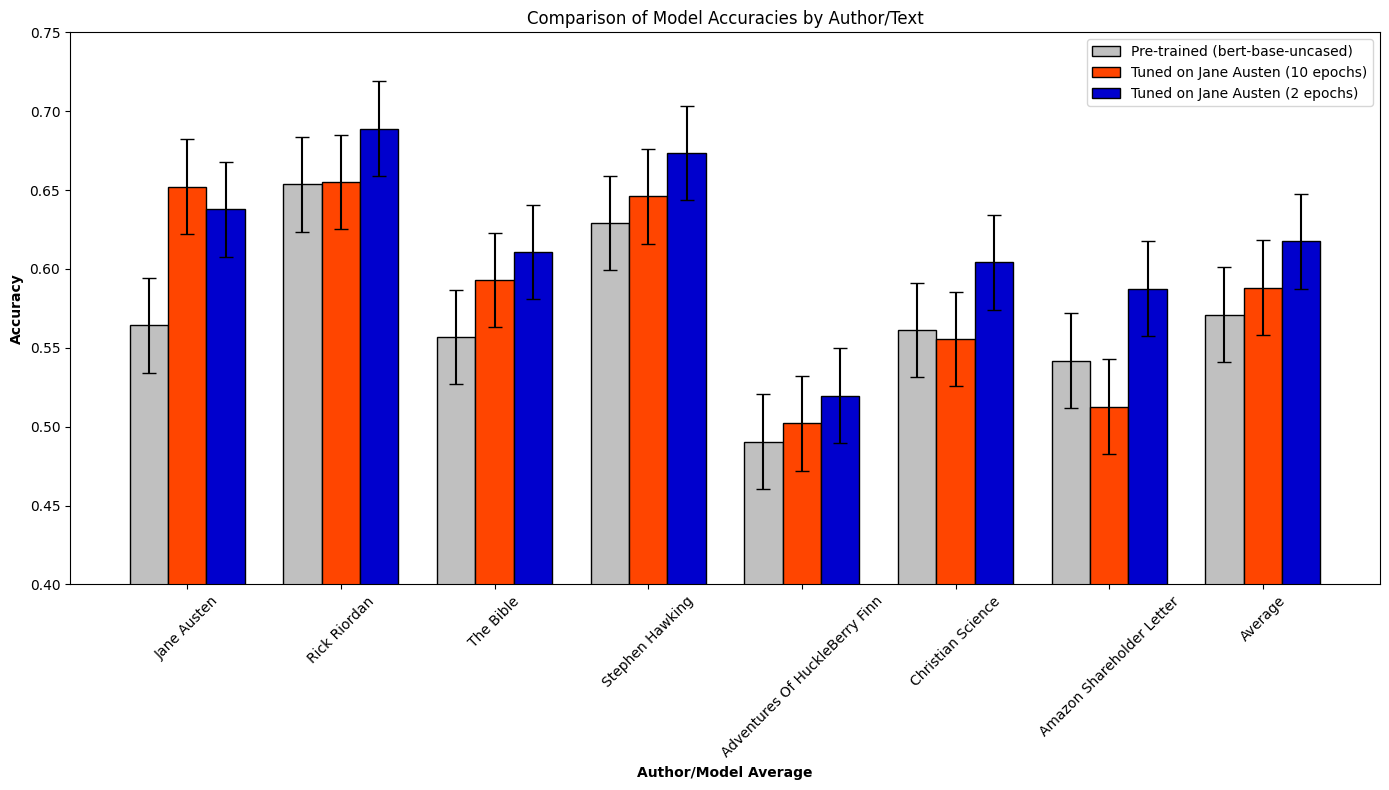

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Authors and their accuracies under different conditions
authors = ['Jane Austen', 'Rick Riordan', 'The Bible', 'Stephen Hawking', 'Adventures Of HuckleBerry Finn', 'Christian Science', 'Amazon Shareholder Letter', 'Average']
pretrained_accuracies = [0.5642, 0.6536, 0.5568, 0.6291, 0.4904, 0.5613, 0.5418]
tuned_10_epochs_accuracies  = [0.6522, 0.6552, 0.5929, 0.6460, 0.5021, 0.5555, 0.5126]
tuned_2_epochs_accuracies = [0.6377, 0.6890, 0.6107, 0.6734, 0.5197, 0.6042, 0.5875]

# Calculate average accuracies for each model
average_accuracies = [np.mean([a for a in model if a is not None]) for model in [pretrained_accuracies, tuned_10_epochs_accuracies, tuned_2_epochs_accuracies]]

# Append averages to the list for plotting as though they were another author
pretrained_accuracies.append(average_accuracies[0])
tuned_10_epochs_accuracies.append(average_accuracies[1])
tuned_2_epochs_accuracies.append(average_accuracies[2])

# Setting the bar width
barWidth = 0.25

# Set position of bar on X axis
r1 = np.arange(len(authors))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

error_margin = [0.03] * len(authors)

# Create the bars
plt.figure(figsize=(14, 8))
plt.bar(r1, pretrained_accuracies, color='silver', width=barWidth, edgecolor='black', yerr=error_margin, capsize=5, label='Pre-trained (bert-base-uncased)')
plt.bar(r2, tuned_10_epochs_accuracies, color='orangered', width=barWidth, edgecolor='black', yerr=error_margin, capsize=5, label='Tuned on Jane Austen (10 epochs)')
plt.bar(r3, tuned_2_epochs_accuracies, color='mediumblue', width=barWidth, edgecolor='black', yerr=error_margin, capsize=5, label='Tuned on Jane Austen (2 epochs)')

# Add xticks on the middle of the group bars
plt.xlabel('Author/Model Average', fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')
plt.ylim(0.4, 0.75)
plt.xticks([r + barWidth for r in range(len(authors))], authors, rotation=45)

# Create legend & Show graphic
plt.legend()
plt.title('Comparison of Model Accuracies by Author/Text')
plt.tight_layout()
plt.show()
